# Parameter Sweeps and Optimization

This notebook demonstrates how to use the `run_sweep` method to systematically test different agent configurations and find optimal parameters.

## Overview

The `run_sweep` method enables:
- **Systematic exploration**: Test multiple parameter combinations
- **Fair comparison**: Same seeds ensure consistent evaluation
- **Flexible tracking**: Use any tracker to collect data
- **Policy factories**: Generate policies from parameter dicts

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:

from experiments import MultiAgentCodenamesExperiment, SummaryTracker, EpisodeTracker
from envs.word_batch_env import WordBatchEnv
from agents.spymaster import RandomSpymaster, EmbeddingSpymaster, SpymasterParams
from agents.guesser import RandomGuesser, EmbeddingGuesser, GuesserParams

# Seaborn style for better plots
sns.set_style('whitegrid')

## 1. Basic Parameter Sweep

Let's sweep over the `n_candidate_clues` parameter for embedding spymasters.

In [3]:
# Check if embedding agents are available
try:
    test_spy = EmbeddingSpymaster(team="red", params=SpymasterParams())
    EMBEDDINGS_AVAILABLE = True
    print("Embedding agents available!")
except RuntimeError:
    EMBEDDINGS_AVAILABLE = False
    print("Embedding agents not available. Install sentence-transformers.")
    print("Falling back to random agents for demonstration.")

Embedding agents available!


In [4]:
# Create experiment
exp = MultiAgentCodenamesExperiment(
    env_factory=lambda seed: WordBatchEnv(batch_size=8, seed=seed),
    max_turns=50
)

if EMBEDDINGS_AVAILABLE:
    # Define policy factory
    def make_policies(params):
        """Create policy map from parameters."""
        n_candidates = params['n_candidate_clues']
        
        red_spy = EmbeddingSpymaster(
            team="red",
            params=SpymasterParams(n_candidate_clues=n_candidates, seed=42)
        )
        blue_spy = EmbeddingSpymaster(
            team="blue",
            params=SpymasterParams(n_candidate_clues=n_candidates, seed=43)
        )
        red_guess = EmbeddingGuesser(team="red", params=GuesserParams(seed=44))
        blue_guess = EmbeddingGuesser(team="blue", params=GuesserParams(seed=45))
        
        return {
            "red_spy": lambda obs: red_spy.get_clue(obs),
            "red_guess": lambda obs: red_guess.get_guess(obs),
            "blue_spy": lambda obs: blue_spy.get_clue(obs),
            "blue_guess": lambda obs: blue_guess.get_guess(obs),
        }
    
    # Define parameter grid
    param_grid = [
        {"n_candidate_clues": 5},
        {"n_candidate_clues": 10},
        {"n_candidate_clues": 20},
        {"n_candidate_clues": 50},
        {"n_candidate_clues": 100},
    ]
    
    print("Running parameter sweep...")
    sweep_results = exp.run_sweep(
        policy_factory=make_policies,
        param_grid=param_grid,
        n_games_per_config=50,
        seed=42,
        verbose=True
    )
    
    print("\nSweep complete!")
else:
    print("Skipping embedding sweep - using random agents for demonstration")
    
    def make_random_policies(params):
        seed_offset = params.get('seed_offset', 0)
        return {
            "red_spy": lambda obs: RandomSpymaster(team="red", params=SpymasterParams(seed=42+seed_offset)).get_clue(obs),
            "red_guess": lambda obs: RandomGuesser(team="red", params=GuesserParams(seed=43+seed_offset)).get_guess(obs),
            "blue_spy": lambda obs: RandomSpymaster(team="blue", params=SpymasterParams(seed=44+seed_offset)).get_clue(obs),
            "blue_guess": lambda obs: RandomGuesser(team="blue", params=GuesserParams(seed=45+seed_offset)).get_guess(obs),
        }
    
    param_grid = [{"seed_offset": i} for i in range(5)]
    sweep_results = exp.run_sweep(
        policy_factory=make_random_policies,
        param_grid=param_grid,
        n_games_per_config=30,
        seed=42
    )

Running parameter sweep...

Configuration 1/5: {'n_candidate_clues': 5}
Completed 8/50 games
Completed 16/50 games
Completed 24/50 games
Completed 32/50 games
Completed 40/50 games
Completed 48/50 games
Completed 50/50 games

Configuration 2/5: {'n_candidate_clues': 10}
Completed 8/50 games
Completed 16/50 games
Completed 24/50 games
Completed 32/50 games
Completed 40/50 games
Completed 48/50 games
Completed 50/50 games

Configuration 3/5: {'n_candidate_clues': 20}
Completed 8/50 games
Completed 16/50 games
Completed 24/50 games
Completed 32/50 games
Completed 40/50 games
Completed 48/50 games
Completed 50/50 games

Configuration 4/5: {'n_candidate_clues': 50}
Completed 8/50 games
Completed 16/50 games
Completed 24/50 games
Completed 32/50 games
Completed 40/50 games
Completed 48/50 games
Completed 50/50 games

Configuration 5/5: {'n_candidate_clues': 100}
Completed 8/50 games
Completed 16/50 games
Completed 24/50 games
Completed 32/50 games
Completed 40/50 games
Completed 48/50 games


## 2. Analyzing Sweep Results

The sweep returns a list of dicts with params, results, and seeds.

In [5]:
# Extract data into DataFrame for easy analysis
if EMBEDDINGS_AVAILABLE:
    sweep_data = []
    for result in sweep_results:
        row = {
            'n_candidate_clues': result['params']['n_candidate_clues'],
            'red_win_rate': result['results']['red_win_rate'],
            'blue_win_rate': result['results']['blue_win_rate'],
            'avg_turns': result['results']['avg_turns'],
            'red_spy_reward': result['results']['rewards_per_agent']['red_spy'],
            'red_guess_reward': result['results']['rewards_per_agent']['red_guess'],
        }
        sweep_data.append(row)
    
    df = pd.DataFrame(sweep_data)
    print(df.to_string(index=False))
else:
    # Random agents - just show structure
    print("Sweep results structure:")
    print(f"Number of configs tested: {len(sweep_results)}")
    print(f"\nExample result:")
    print(f"  Params: {sweep_results[0]['params']}")
    print(f"  Red win rate: {sweep_results[0]['results']['red_win_rate']:.2%}")
    print(f"  Avg turns: {sweep_results[0]['results']['avg_turns']:.1f}")

 n_candidate_clues  red_win_rate  blue_win_rate  avg_turns  red_spy_reward  red_guess_reward
                 5          0.44           0.56       6.88          -10.24            -10.24
                10          0.42           0.58       8.46          -10.14            -10.14
                20          0.50           0.50       7.42           -8.52             -8.52
                50          0.38           0.62      10.50          -10.68            -10.68
               100          0.40           0.60       8.48          -10.70            -10.70


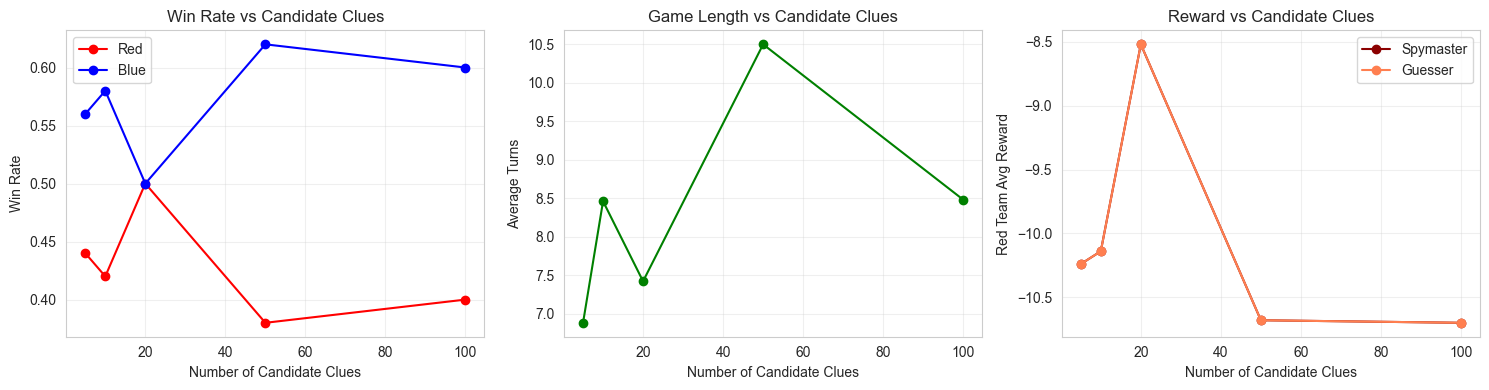


Best configuration:
  n_candidate_clues: 20
  Red win rate: 50.00%
  Avg reward: -8.52


In [6]:
if EMBEDDINGS_AVAILABLE:
    # Plot results
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Win rate vs n_candidates
    axes[0].plot(df['n_candidate_clues'], df['red_win_rate'], 'o-', label='Red', color='red')
    axes[0].plot(df['n_candidate_clues'], df['blue_win_rate'], 'o-', label='Blue', color='blue')
    axes[0].set_xlabel('Number of Candidate Clues')
    axes[0].set_ylabel('Win Rate')
    axes[0].set_title('Win Rate vs Candidate Clues')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Average turns vs n_candidates
    axes[1].plot(df['n_candidate_clues'], df['avg_turns'], 'o-', color='green')
    axes[1].set_xlabel('Number of Candidate Clues')
    axes[1].set_ylabel('Average Turns')
    axes[1].set_title('Game Length vs Candidate Clues')
    axes[1].grid(True, alpha=0.3)
    
    # Rewards vs n_candidates
    axes[2].plot(df['n_candidate_clues'], df['red_spy_reward'], 'o-', label='Spymaster', color='darkred')
    axes[2].plot(df['n_candidate_clues'], df['red_guess_reward'], 'o-', label='Guesser', color='coral')
    axes[2].set_xlabel('Number of Candidate Clues')
    axes[2].set_ylabel('Red Team Avg Reward')
    axes[2].set_title('Reward vs Candidate Clues')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Find optimal
    best_idx = df['red_spy_reward'].idxmax()
    print(f"\nBest configuration:")
    print(f"  n_candidate_clues: {df.iloc[best_idx]['n_candidate_clues']:.0f}")
    print(f"  Red win rate: {df.iloc[best_idx]['red_win_rate']:.2%}")
    print(f"  Avg reward: {df.iloc[best_idx]['red_spy_reward']:.2f}")

## 3. Multi-Dimensional Parameter Sweep

Let's sweep over multiple parameters simultaneously.

In [7]:
if EMBEDDINGS_AVAILABLE:
    # Define 2D parameter grid
    def make_policies_2d(params):
        n_candidates = params['n_candidate_clues']
        risk_tolerance = params['risk_tolerance']
        
        red_spy = EmbeddingSpymaster(
            team="red",
            params=SpymasterParams(
                n_candidate_clues=n_candidates,
                risk_tolerance=risk_tolerance,
                seed=42
            )
        )
        blue_spy = EmbeddingSpymaster(
            team="blue",
            params=SpymasterParams(
                n_candidate_clues=n_candidates,
                risk_tolerance=risk_tolerance,
                seed=43
            )
        )
        red_guess = EmbeddingGuesser(team="red", params=GuesserParams(seed=44))
        blue_guess = EmbeddingGuesser(team="blue", params=GuesserParams(seed=45))
        
        return {
            "red_spy": lambda obs: red_spy.get_clue(obs),
            "red_guess": lambda obs: red_guess.get_guess(obs),
            "blue_spy": lambda obs: blue_spy.get_clue(obs),
            "blue_guess": lambda obs: blue_guess.get_guess(obs),
        }
    
    # Grid search
    param_grid_2d = []
    for n_candidates in [10, 20, 50]:
        for risk in [1.0, 2.0, 3.0]:
            param_grid_2d.append({
                'n_candidate_clues': n_candidates,
                'risk_tolerance': risk
            })
    
    print(f"Testing {len(param_grid_2d)} configurations...")
    sweep_2d_results = exp.run_sweep(
        policy_factory=make_policies_2d,
        param_grid=param_grid_2d,
        n_games_per_config=30,
        seed=42,
        verbose=False
    )
    
    # Extract to DataFrame
    sweep_2d_data = []
    for result in sweep_2d_results:
        row = {
            'n_candidate_clues': result['params']['n_candidate_clues'],
            'risk_tolerance': result['params']['risk_tolerance'],
            'red_win_rate': result['results']['red_win_rate'],
            'avg_turns': result['results']['avg_turns'],
            'red_spy_reward': result['results']['rewards_per_agent']['red_spy'],
        }
        sweep_2d_data.append(row)
    
    df_2d = pd.DataFrame(sweep_2d_data)
    print("\n2D Sweep Results:")
    print(df_2d.to_string(index=False))
else:
    print("Skipping 2D sweep (requires embedding agents)")

Testing 9 configurations...

2D Sweep Results:
 n_candidate_clues  risk_tolerance  red_win_rate  avg_turns  red_spy_reward
                10             1.0      0.533333   6.133333       -8.300000
                10             2.0      0.366667   7.733333      -10.800000
                10             3.0      0.366667   7.300000      -11.533334
                20             1.0      0.333333  10.166667      -11.800000
                20             2.0      0.533333   8.800000       -6.333333
                20             3.0      0.600000   7.933333       -5.366667
                50             1.0      0.433333   7.033333      -10.266666
                50             2.0      0.500000   7.300000       -8.433333
                50             3.0      0.466667   8.100000       -9.033334


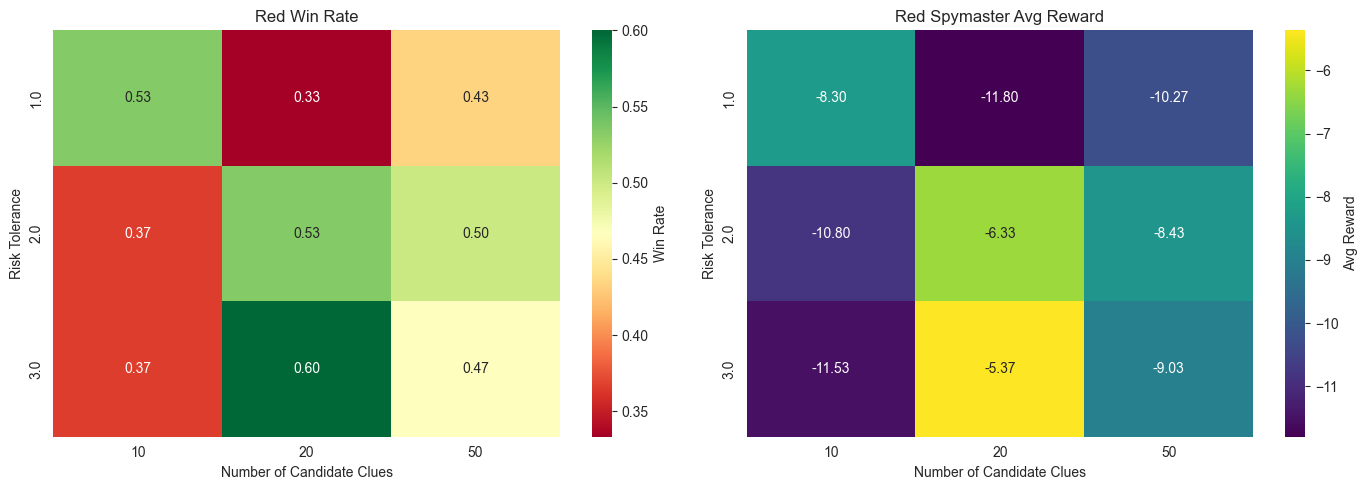


Optimal configuration:
  n_candidate_clues: 20
  risk_tolerance: 3.0
  Red win rate: 60.00%
  Avg reward: -5.37


In [8]:
if EMBEDDINGS_AVAILABLE:
    # Create heatmap
    pivot_win_rate = df_2d.pivot(index='risk_tolerance', columns='n_candidate_clues', values='red_win_rate')
    pivot_reward = df_2d.pivot(index='risk_tolerance', columns='n_candidate_clues', values='red_spy_reward')
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Win rate heatmap
    sns.heatmap(pivot_win_rate, annot=True, fmt='.2f', cmap='RdYlGn', ax=axes[0], cbar_kws={'label': 'Win Rate'})
    axes[0].set_title('Red Win Rate')
    axes[0].set_xlabel('Number of Candidate Clues')
    axes[0].set_ylabel('Risk Tolerance')
    
    # Reward heatmap
    sns.heatmap(pivot_reward, annot=True, fmt='.2f', cmap='viridis', ax=axes[1], cbar_kws={'label': 'Avg Reward'})
    axes[1].set_title('Red Spymaster Avg Reward')
    axes[1].set_xlabel('Number of Candidate Clues')
    axes[1].set_ylabel('Risk Tolerance')
    
    plt.tight_layout()
    plt.show()
    
    # Find optimal combination
    best_idx = df_2d['red_spy_reward'].idxmax()
    print(f"\nOptimal configuration:")
    print(f"  n_candidate_clues: {df_2d.iloc[best_idx]['n_candidate_clues']:.0f}")
    print(f"  risk_tolerance: {df_2d.iloc[best_idx]['risk_tolerance']:.1f}")
    print(f"  Red win rate: {df_2d.iloc[best_idx]['red_win_rate']:.2%}")
    print(f"  Avg reward: {df_2d.iloc[best_idx]['red_spy_reward']:.2f}")

## 4. Asymmetric Agent Comparison

Compare different agent types (e.g., random vs embedding).

In [9]:
if EMBEDDINGS_AVAILABLE:
    # Test different team compositions
    def make_asymmetric_policies(params):
        red_type = params['red_type']
        blue_type = params['blue_type']
        
        # Create red agents
        if red_type == 'random':
            red_spy = RandomSpymaster(team="red")
            red_guess = RandomGuesser(team="red")
        else:  # embedding
            red_spy = EmbeddingSpymaster(team="red", params=SpymasterParams(n_candidate_clues=20, seed=42))
            red_guess = EmbeddingGuesser(team="red", params=GuesserParams(seed=43))
        
        # Create blue agents
        if blue_type == 'random':
            blue_spy = RandomSpymaster(team="blue")
            blue_guess = RandomGuesser(team="blue")
        else:  # embedding
            blue_spy = EmbeddingSpymaster(team="blue", params=SpymasterParams(n_candidate_clues=20, seed=44))
            blue_guess = EmbeddingGuesser(team="blue", params=GuesserParams(seed=45))
        
        return {
            "red_spy": lambda obs: red_spy.get_clue(obs),
            "red_guess": lambda obs: red_guess.get_guess(obs),
            "blue_spy": lambda obs: blue_spy.get_clue(obs),
            "blue_guess": lambda obs: blue_guess.get_guess(obs),
        }
    
    # Test all combinations
    asymmetric_grid = [
        {'red_type': 'random', 'blue_type': 'random'},
        {'red_type': 'random', 'blue_type': 'embedding'},
        {'red_type': 'embedding', 'blue_type': 'random'},
        {'red_type': 'embedding', 'blue_type': 'embedding'},
    ]
    
    print("Testing asymmetric matchups...")
    asymmetric_results = exp.run_sweep(
        policy_factory=make_asymmetric_policies,
        param_grid=asymmetric_grid,
        n_games_per_config=50,
        seed=42
    )
    
    # Display results
    print("\n=== Asymmetric Matchup Results ===")
    for result in asymmetric_results:
        red_type = result['params']['red_type']
        blue_type = result['params']['blue_type']
        red_wr = result['results']['red_win_rate']
        blue_wr = result['results']['blue_win_rate']
        avg_turns = result['results']['avg_turns']
        
        print(f"\n{red_type:10s} vs {blue_type:10s}")
        print(f"  Red win rate:  {red_wr:.2%}")
        print(f"  Blue win rate: {blue_wr:.2%}")
        print(f"  Draw rate:     {(1 - red_wr - blue_wr):.2%}")
        print(f"  Avg turns:     {avg_turns:.1f}")
else:
    print("Skipping asymmetric comparison (requires embedding agents)")

Testing asymmetric matchups...

=== Asymmetric Matchup Results ===

random     vs random    
  Red win rate:  52.00%
  Blue win rate: 48.00%
  Draw rate:     0.00%
  Avg turns:     9.2

random     vs embedding 
  Red win rate:  40.00%
  Blue win rate: 60.00%
  Draw rate:     0.00%
  Avg turns:     8.9

embedding  vs random    
  Red win rate:  56.00%
  Blue win rate: 44.00%
  Draw rate:     -0.00%
  Avg turns:     8.1

embedding  vs embedding 
  Red win rate:  42.00%
  Blue win rate: 58.00%
  Draw rate:     0.00%
  Avg turns:     10.3


## 5. Statistical Significance Testing

Use episode-level data to assess if differences are significant.

In [10]:
if EMBEDDINGS_AVAILABLE:
    from scipy import stats
    
    # Compare two specific configurations with episode tracker
    config_a = {'n_candidate_clues': 10}
    config_b = {'n_candidate_clues': 50}
    
    # Run with episode tracker
    tracker_a = EpisodeTracker()
    exp.run_games(
        policy_map=make_policies(config_a),
        n_games=100,
        tracker=tracker_a,
        seed=42
    )
    
    tracker_b = EpisodeTracker()
    exp.run_games(
        policy_map=make_policies(config_b),
        n_games=100,
        tracker=tracker_b,
        seed=42  # Same seed for paired comparison
    )
    
    # Extract rewards
    rewards_a = [ep['total_rewards']['red_spy'] for ep in tracker_a.get_results()]
    rewards_b = [ep['total_rewards']['red_spy'] for ep in tracker_b.get_results()]
    
    # Paired t-test (same seeds = paired data)
    t_stat, p_value = stats.ttest_rel(rewards_a, rewards_b)
    
    print(f"Configuration A (n_candidates={config_a['n_candidate_clues']}):")
    print(f"  Mean reward: {np.mean(rewards_a):.2f} ± {np.std(rewards_a):.2f}")
    
    print(f"\nConfiguration B (n_candidates={config_b['n_candidate_clues']}):")
    print(f"  Mean reward: {np.mean(rewards_b):.2f} ± {np.std(rewards_b):.2f}")
    
    print(f"\nPaired t-test:")
    print(f"  t-statistic: {t_stat:.3f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Significant (p < 0.05): {p_value < 0.05}")
    
    # Plot distributions
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].hist(rewards_a, bins=20, alpha=0.5, label=f'A (n={config_a["n_candidate_clues"]})', color='blue')
    axes[0].hist(rewards_b, bins=20, alpha=0.5, label=f'B (n={config_b["n_candidate_clues"]})', color='red')
    axes[0].axvline(np.mean(rewards_a), color='blue', linestyle='--')
    axes[0].axvline(np.mean(rewards_b), color='red', linestyle='--')
    axes[0].set_xlabel('Episode Reward')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Reward Distributions')
    axes[0].legend()
    
    # Paired differences
    differences = np.array(rewards_b) - np.array(rewards_a)
    axes[1].hist(differences, bins=20, edgecolor='black', alpha=0.7)
    axes[1].axvline(0, color='red', linestyle='--', label='No difference')
    axes[1].axvline(np.mean(differences), color='green', linestyle='--', label=f'Mean diff: {np.mean(differences):.2f}')
    axes[1].set_xlabel('Reward Difference (B - A)')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Paired Differences')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("Skipping significance testing (requires embedding agents)")

ValueError: operands could not be broadcast together with shapes (8,) (4,) (8,) 

## 6. Saving and Loading Results

Save sweep results for later analysis.

In [11]:
import json

if EMBEDDINGS_AVAILABLE:
    # Save sweep results
    def save_sweep_results(results, filename):
        """Save sweep results to JSON."""
        # Convert numpy types to native Python types
        serializable_results = []
        for result in results:
            serializable = {
                'params': result['params'],
                'seed': int(result['seed']),
                'results': {
                    'total_games': int(result['results']['total_games']),
                    'red_win_rate': float(result['results']['red_win_rate']),
                    'blue_win_rate': float(result['results']['blue_win_rate']),
                    'avg_turns': float(result['results']['avg_turns']),
                    'rewards_per_agent': {
                        k: float(v) for k, v in result['results']['rewards_per_agent'].items()
                    }
                }
            }
            serializable_results.append(serializable)
        
        with open(filename, 'w') as f:
            json.dump(serializable_results, f, indent=2)
        
        print(f"Saved results to {filename}")
    
    # Save results
    save_sweep_results(sweep_results, 'sweep_results.json')
    
    # Load results
    def load_sweep_results(filename):
        """Load sweep results from JSON."""
        with open(filename, 'r') as f:
            return json.load(f)
    
    loaded_results = load_sweep_results('sweep_results.json')
    print(f"\nLoaded {len(loaded_results)} configurations")
else:
    print("Skipping save/load (no sweep results available)")

Saved results to sweep_results.json

Loaded 5 configurations


## Summary

You now know how to:
- Use `run_sweep` for systematic parameter exploration
- Analyze and visualize sweep results
- Perform multi-dimensional parameter sweeps
- Compare asymmetric agent matchups
- Test statistical significance of differences
- Save and load results for reproducibility

## Next Steps

- Implement more sophisticated optimization (Bayesian optimization, evolutionary strategies)
- Train RL agents using the insights from parameter sweeps
- Build ensemble policies that combine multiple configurations
- Analyze failure modes and edge cases